In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
sleepset1 = pd.read_csv("sleepdata.csv", delimiter=";")
sleepset2 = pd.read_csv("sleepdata_2.csv", delimiter=";")

def bettersleepset(df):
    for col in df:
        df[col.lower()] = df.pop(col)
    df['start'] = pd.to_datetime(df['start'])
    df['end'] = pd.to_datetime(df['end'])
    df['time in bed'] = (df['end'] - df['start']).astype('timedelta64[s]') / 60 / 60
    df['start'] = ((df['start'].dt.hour * 60 + df['start'].dt.minute - 60 * 12) % (60 * 24) + 60 * 12) / 60
    df['end'] = (df['end'].dt.hour * 60 + df['end'].dt.minute) / 60
    if 'window start' in df and 'window stop' in df:
        df['window start'] = pd.to_datetime(df['window start'])
        df['window stop'] = pd.to_datetime(df['window stop'])
        df['window time'] = (df['window stop'] - df['window start']).astype('timedelta64[s]') / 60 / 60
        df.pop('window start')
        df.pop('window stop')

    if 'sleep quality' in df:
        df['sleep quality'] = df['sleep quality'].apply(lambda x: np.nan if x in ['-'] else x[:-1]).astype(int)
    if 'regularity' in df:
        df['regularity'] = df['regularity'].apply(lambda x: np.nan if x in ['-'] else x[:-1]).astype(int)

    if 'time asleep (seconds)' in df:
        df['time asleep'] = df.pop('time asleep (seconds)') / 60 / 60
    if 'time before sleep (seconds)' in df:
        df['time before sleep'] = df.pop('time before sleep (seconds)') / 60 / 60

    # data clearing
    df = df[df['time in bed'] >= 1] # more than 1 hour, because people can "dream"
    return df

sleepset1 = bettersleepset(sleepset1)
sleepset2 = bettersleepset(sleepset2)

sleepset1.info()
sleepset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876 entries, 0 to 886
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start             876 non-null    float64
 1   end               876 non-null    float64
 2   sleep quality     876 non-null    int64  
 3   time in bed       876 non-null    float64
 4   wake up           243 non-null    object 
 5   sleep notes       650 non-null    object 
 6   heart rate        161 non-null    float64
 7   activity (steps)  876 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 61.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 920
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   start                     917 non-null    float64
 1   end                       917 non-null    float64
 2   sleep quality             917 non

In [4]:
corr1 = sleepset1.corr()
corr1.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_12616/223571405.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr1 = sleepset1.corr()


,start,end,sleep quality,time in bed,heart rate,activity (steps)
start,1.000000,0.517504,-0.365847,-0.688328,0.170837,0.114937
end,0.517504,1.000000,0.191092,0.264473,0.231462,0.104450
sleep quality,-0.365847,0.191092,1.000000,0.574228,0.018310,-0.236482
time in bed,-0.688328,0.264473,0.574228,1.000000,0.009855,-0.040898
heart rate,0.170837,0.231462,0.018310,0.009855,1.000000,nan
activity (steps),0.114937,0.104450,-0.236482,-0.040898,nan,1.000000


In [5]:
corr2 = sleepset2.corr()
corr2.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_12616/1291505923.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr2 = sleepset2.corr()
/usr/lib/python3/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/lib/python3/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,start,end,sleep quality,regularity,mood,heart rate (bpm),steps,air pressure (pa),movements per hour,time in bed (seconds),did snore,snore time,weather temperature (°c),time in bed,window time,time asleep,time before sleep
start,1.000000,0.463103,-0.191679,-0.234655,nan,nan,0.128898,0.054070,0.037868,-0.384671,-0.008532,-0.086935,0.020181,-0.382395,0.054918,-0.291486,-0.129339
end,0.463103,1.000000,0.244201,-0.119513,nan,nan,0.007215,-0.095130,-0.074395,0.385788,-0.153876,-0.005741,-0.100129,0.388670,0.023363,0.394929,-0.081324
sleep quality,-0.191679,0.244201,1.000000,0.218147,nan,nan,-0.063701,-0.120457,-0.098375,0.605715,0.092299,-0.044181,-0.007762,0.603600,-0.050021,0.634559,0.095000
regularity,-0.234655,-0.119513,0.218147,1.000000,nan,nan,-0.003025,-0.132323,0.018533,0.179313,0.016069,-0.015590,0.002197,0.181615,-0.003028,0.174248,0.034409
mood,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
heart rate (bpm),nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
steps,0.128898,0.007215,-0.063701,-0.003025,nan,nan,1.000000,-0.121183,0.101563,-0.083581,0.113556,0.025698,0.020316,-0.085409,0.134755,-0.073191,-0.023096
air pressure (pa),0.054070,-0.095130,-0.120457,-0.132323,nan,nan,-0.121183,1.000000,0.121743,-0.203418,-0.042019,0.081168,0.223811,-0.201067,0.041399,-0.207831,0.258871
movements per hour,0.037868,-0.074395,-0.098375,0.018533,nan,nan,0.101563,0.121743,1.000000,-0.122805,-0.020435,-0.024210,0.197892,-0.122945,0.113725,-0.072704,-0.086783
time in bed (seconds),-0.384671,0.385788,0.605715,0.179313,nan,nan,-0.083581,-0.203418,-0.122805,1.000000,0.103176,0.096083,-0.132539,0.998325,-0.024593,0.886320,0.052338


Общий код предварительного анализа: (Все последующие графики опираются на него)

In [6]:
def preanalysis_part1(datagram, namefield):
    cleared = datagram[namefield].dropna()
    sb.histplot(data = cleared)
    plt.show()

def preanalysis_part2(datagram, namefield1, namefield2):
    cleared = datagram[[namefield1, namefield2]].dropna()
    if np.dtype(datagram[namefield1]) == "object" or np.dtype(datagram[namefield2]) == "object":
        sb.histplot(cleared, x=namefield1, y=namefield2)
        plt.xlabel(namefield1)
        plt.ylabel(namefield2)
        plt.show()
    else:
        cleared.plot(x=namefield1, y=namefield2, kind='scatter')
        plt.xlabel(namefield1)
        plt.ylabel(namefield2)
        plt.show()

def preanalysis_part3(datagram, namefield1, namefield2):
    if np.dtype(datagram[namefield1]) in ["int64", "float64"] and np.dtype(datagram[namefield2]) in ["int64", "float64"]:
        cleared = datagram[[namefield1, namefield2]].dropna()

        lower = cleared[namefield1].quantile(0.4)
        upper = cleared[namefield1].quantile(0.7)
        lowercnt = middlecnt = uppercnt = 0

        toshowdata = pd.DataFrame(columns = [namefield1, namefield2])
        for index, row in cleared.iterrows():
            if row[namefield1] < lower:
                toshowdata.loc[len(toshowdata.index)] = ["lower", row[namefield2]]
                lowercnt += 1
            elif row[namefield1] < upper:
                toshowdata.loc[len(toshowdata.index)] = ["middle", row[namefield2]]
                middlecnt += 1
            else:
                toshowdata.loc[len(toshowdata.index)] = ["upper", row[namefield2]]
                uppercnt += 1
        print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

        sb.violinplot(data = toshowdata.sort_values(namefield1), x = namefield1, y = namefield2)
        plt.show()

# def readcommonset(filename):
#     df = pd.read_csv(filename, delimiter=",")
#     for col in df:
#         df[col.lower()] = df.pop(col)
#     if "person id" in df:
#         df.pop("person id")
#     if "blood pressure" in df:
#         df["blood pressure high level"] = df["age"]
#         df["blood pressure low level"] = df["age"]
#         for ind, row in df.iterrows():
#             bloodrow = list(map(int, df.loc[ind]["blood pressure"].split('/')))
#             df.loc[ind, "blood pressure high level"] = bloodrow[0]
#             df.loc[ind, "blood pressure low level"] = bloodrow[1]
#         df.pop("blood pressure")
#     return df

def preanalysis(datagram):
    for namefield in datagram:
        print("Histogram graph of " + namefield)
        preanalysis_part1(datagram, namefield)
    for namefield1 in datagram:
        for namefield2 in datagram:
            if namefield1 < namefield2:
                print("Scatter graph of " + namefield1 + " and " + namefield2)
                preanalysis_part2(datagram, namefield1, namefield2)
    for namefield1 in datagram:
        for namefield2 in datagram:
            if namefield1 != namefield2:
                print("Violin graph of " + namefield1 + " and " + namefield2)
                preanalysis_part3(datagram, namefield1, namefield2)

Simple graphs of dataset

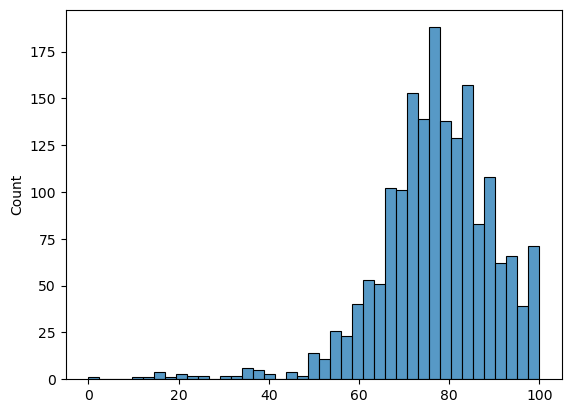

In [7]:
cleared = np.concatenate([sleepset1["sleep quality"].dropna(), sleepset2["sleep quality"].dropna()])
sb.histplot(data = cleared)
plt.show()

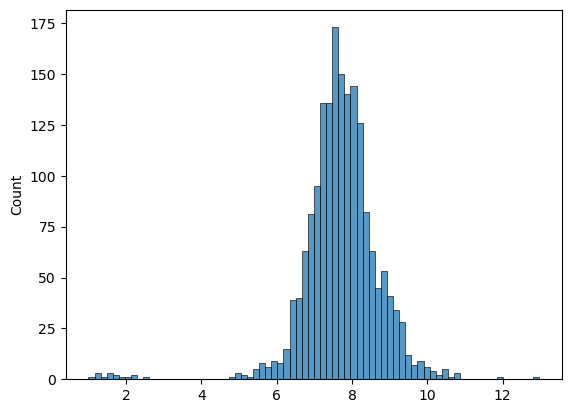

In [8]:
cleared = (np.concatenate([sleepset1["time in bed"].dropna(), sleepset2["time in bed"].dropna()]))
sb.histplot(data = cleared)
plt.show()

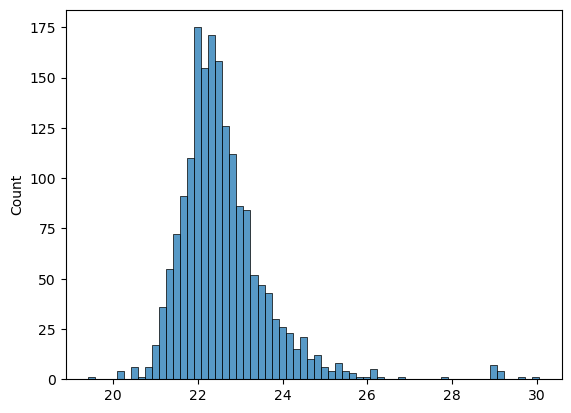

In [9]:
cleared = (np.concatenate([sleepset1["start"].dropna(), sleepset2["start"].dropna()]))
sb.histplot(data = cleared)
plt.show()

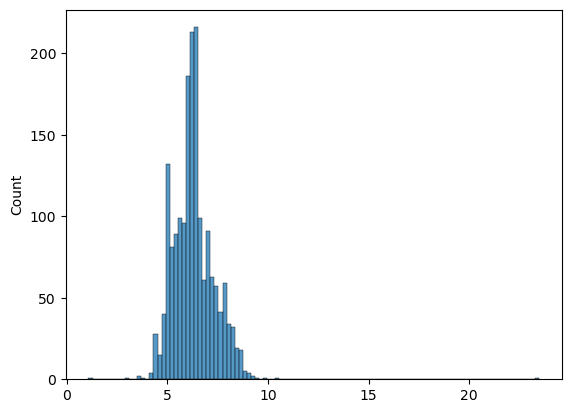

In [10]:
cleared = (np.concatenate([sleepset1["end"].dropna(), sleepset2["end"].dropna()]))
sb.histplot(data = cleared)
plt.show()

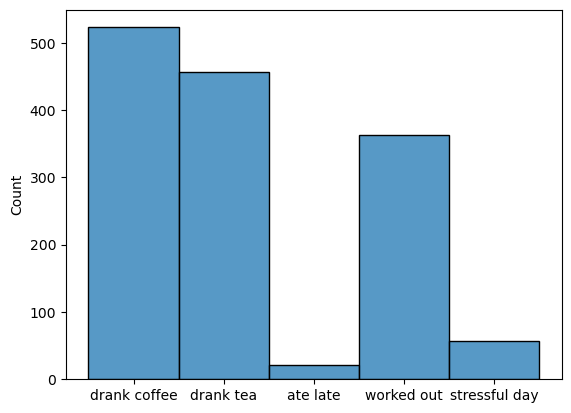

In [11]:
cleared = list()
for notes in sleepset1["sleep notes"].dropna():
    for note in notes.lower().split(':'):
        cleared.append(note)
sb.histplot(data = cleared)
plt.show()

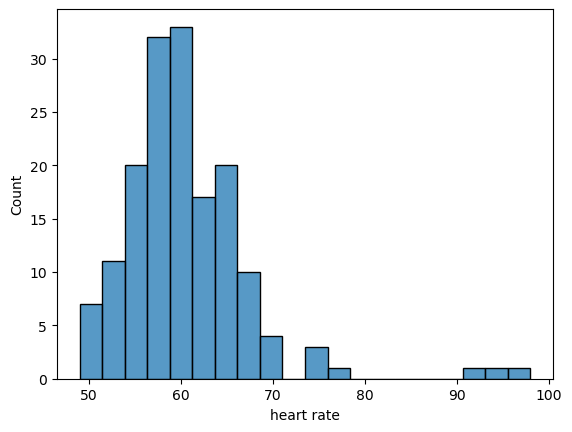

In [12]:
cleared = sleepset1["heart rate"].dropna()
sb.histplot(data = cleared)
plt.show()

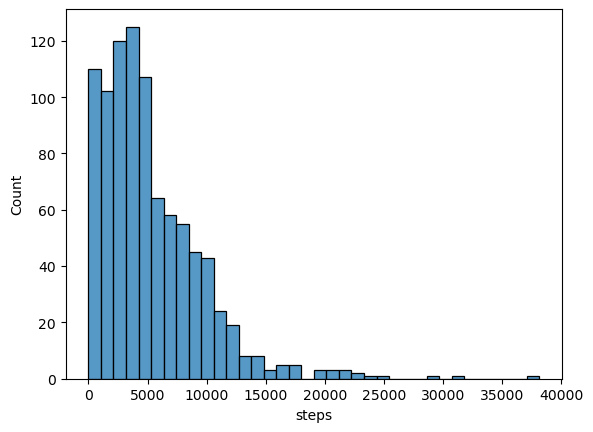

In [13]:
cleared = sleepset2["steps"].dropna()
sb.histplot(data = cleared)
plt.show()

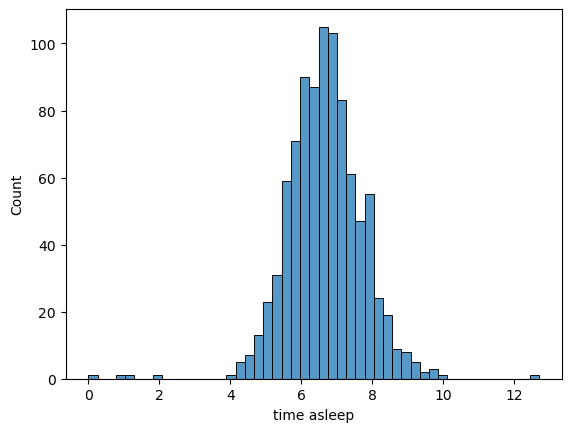

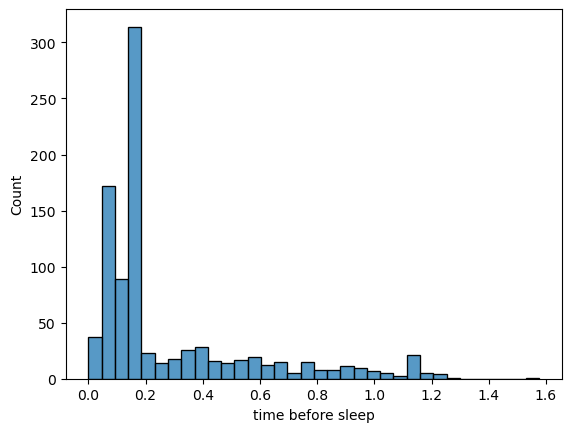

In [14]:
cleared = sleepset2["time asleep"].dropna()
sb.histplot(data = cleared)
plt.show()
cleared = sleepset2["time before sleep"].dropna()
sb.histplot(data = cleared)
plt.show()

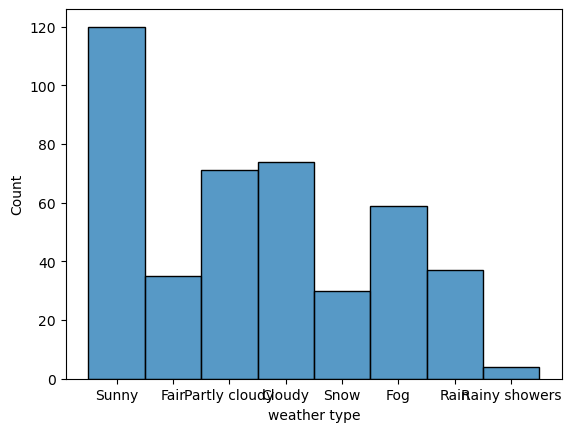

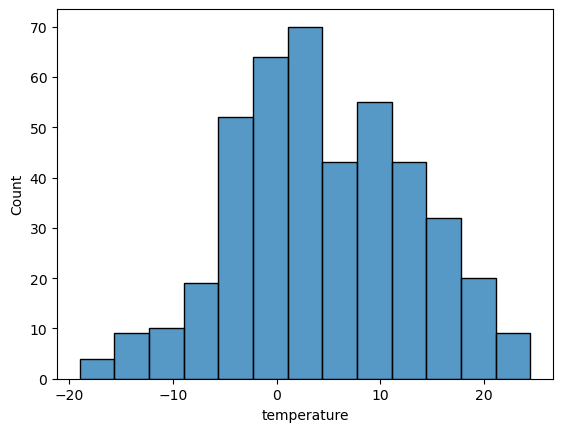

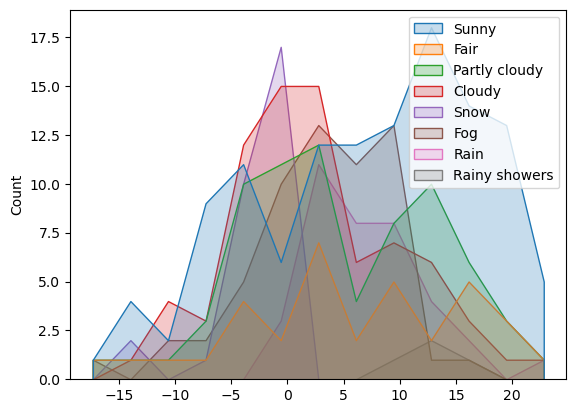

In [15]:
cleared = sleepset2[["weather type", "weather temperature (°c)"]].dropna()
cleared_weather = list()
cleared_temperature = list()
cleared_weather_temperature = dict()
for index, weather in cleared.iterrows():
    if weather["weather type"] != "No weather":
        cleared_weather.append(weather["weather type"])
        cleared_temperature.append(weather["weather temperature (°c)"])
        if weather["weather type"] in cleared_weather_temperature:
            cleared_weather_temperature[weather["weather type"]].append(weather["weather temperature (°c)"])
        else:
            cleared_weather_temperature[weather["weather type"]] = [weather["weather temperature (°c)"]]
sb.histplot(data = {"weather type" : cleared_weather}, x = "weather type")
plt.show()
sb.histplot(data = {"temperature" : cleared_temperature}, x = "temperature")
plt.show()
sb.histplot(data = cleared_weather_temperature, element="poly")
plt.show()

More graphs - scatter

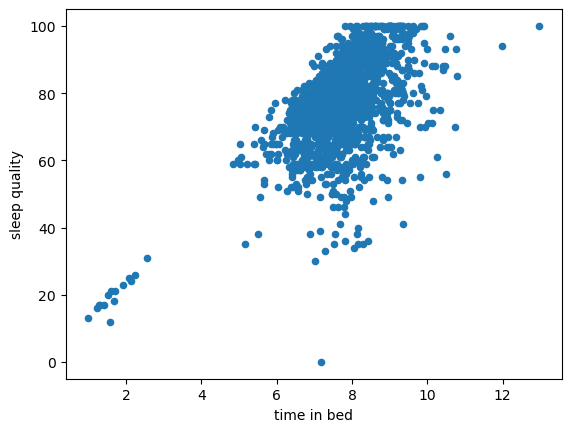

In [16]:
first = "time in bed"
second = "sleep quality"
cleared = pd.concat([sleepset1[[first, second]].dropna(), sleepset2[[first, second]].dropna()])
# cleared = cleared[np.logical_and(cleared[first] != 0, cleared[second] != 0)]
#np.dtype(cleared[first]) in ["int64", "float64"] and 

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

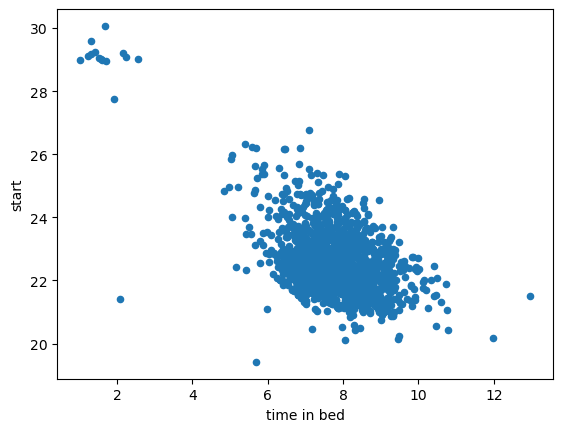

In [17]:
first = "time in bed"
second = "start"
cleared = pd.concat([sleepset1[[first, second]].dropna(), sleepset2[[first, second]].dropna()])
# cleared = cleared[np.logical_and(cleared[first] != 0, cleared[second] != 0)]
#np.dtype(cleared[first]) in ["int64", "float64"] and 

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

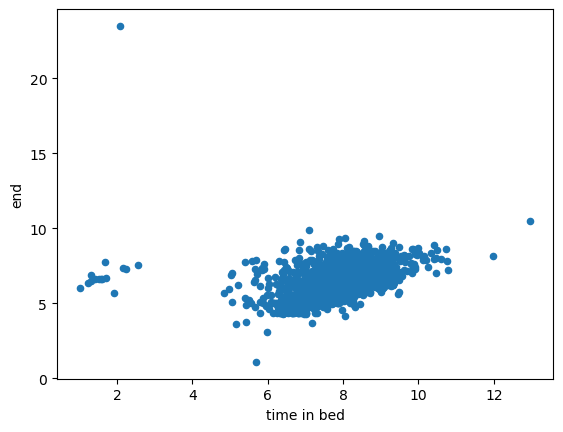

In [18]:
first = "time in bed"
second = "end"
cleared = pd.concat([sleepset1[[first, second]].dropna(), sleepset2[[first, second]].dropna()])
# cleared = cleared[np.logical_and(cleared[first] != 0, cleared[second] != 0)]
#np.dtype(cleared[first]) in ["int64", "float64"] and 

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

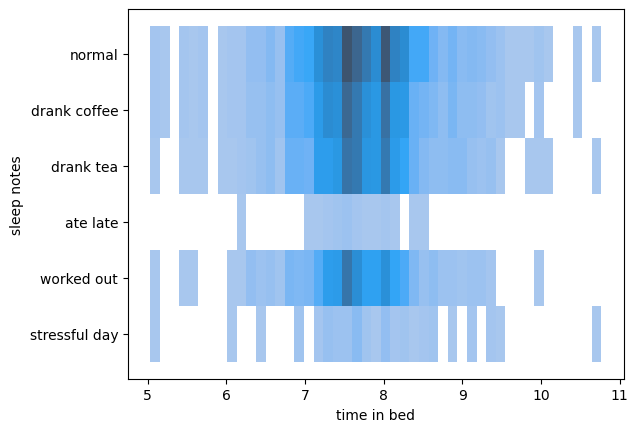

In [19]:
cleared = sleepset1[["time in bed", "sleep notes"]].dropna()
cleared_notes = pd.DataFrame(columns=["time in bed", "sleep notes"])
for index, df in cleared.iterrows():
    tmbed = df["time in bed"]
    notes = df["sleep notes"]
    cleared_notes.loc[len(cleared_notes.index)] = [tmbed, "normal"]
    for note in notes.lower().split(':'):
        cleared_notes.loc[len(cleared_notes.index)] = [tmbed, note]

sb.histplot(data = cleared_notes, x="time in bed", y="sleep notes")
plt.show()

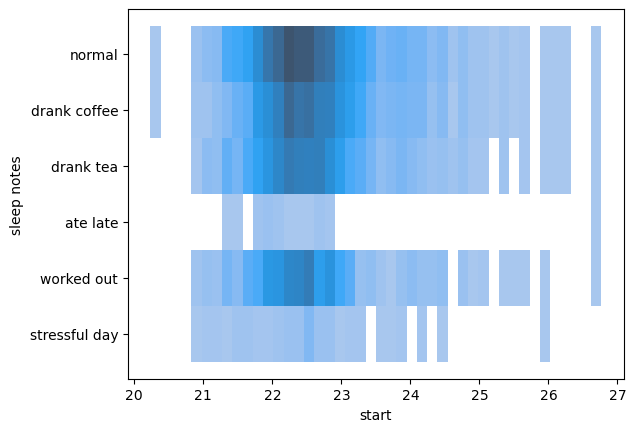

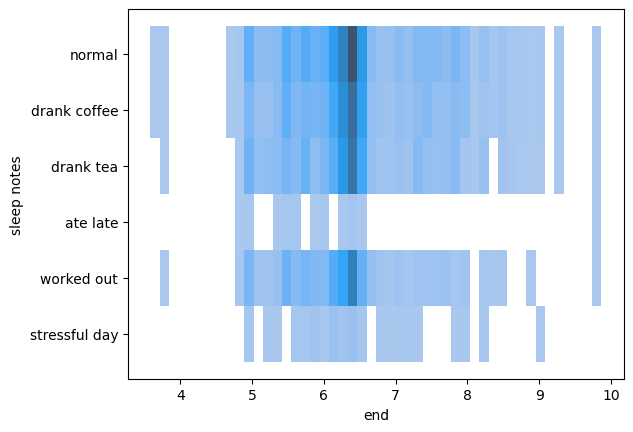

In [20]:
cleared = sleepset1[["start", "sleep notes"]].dropna()
cleared_notes = pd.DataFrame(columns=["start", "sleep notes"])
for index, df in cleared.iterrows():
    tmbed = df["start"]
    notes = df["sleep notes"]
    cleared_notes.loc[len(cleared_notes.index)] = [tmbed, "normal"]
    for note in notes.lower().split(':'):
        cleared_notes.loc[len(cleared_notes.index)] = [tmbed, note]

sb.histplot(data = cleared_notes, x="start", y="sleep notes")
plt.show()
cleared = sleepset1[["end", "sleep notes"]].dropna()
cleared_notes = pd.DataFrame(columns=["end", "sleep notes"])
for index, df in cleared.iterrows():
    tmbed = df["end"]
    notes = df["sleep notes"]
    cleared_notes.loc[len(cleared_notes.index)] = [tmbed, "normal"]
    for note in notes.lower().split(':'):
        cleared_notes.loc[len(cleared_notes.index)] = [tmbed, note]

sb.histplot(data = cleared_notes, x="end", y="sleep notes")
plt.show()

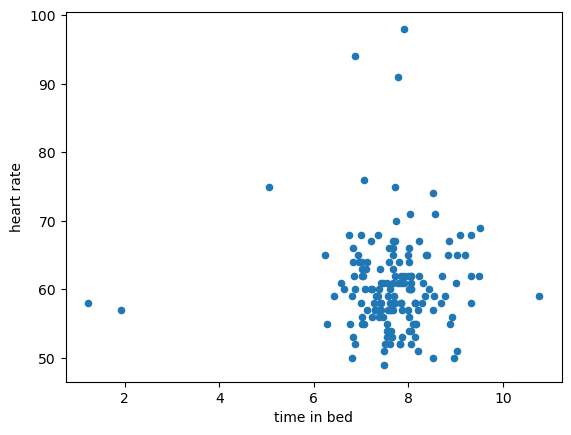

In [21]:
first = "time in bed"
second = "heart rate"
cleared = sleepset1[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

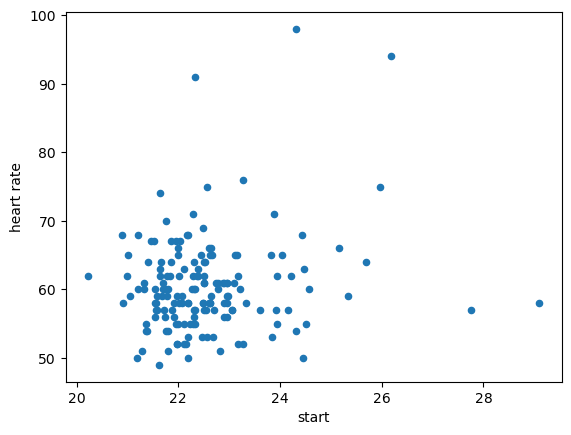

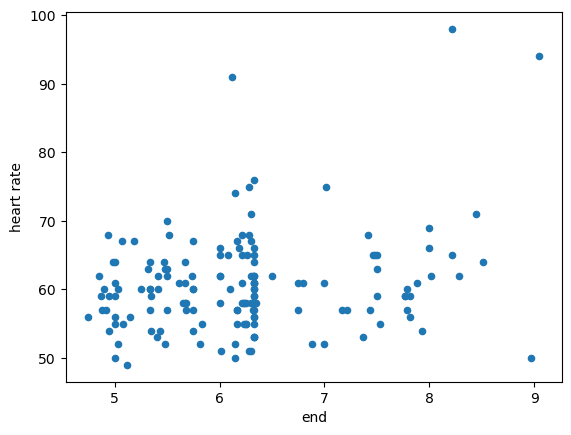

In [22]:
first = "start"
second = "heart rate"
cleared = sleepset1[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()
first = "end"
second = "heart rate"
cleared = sleepset1[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

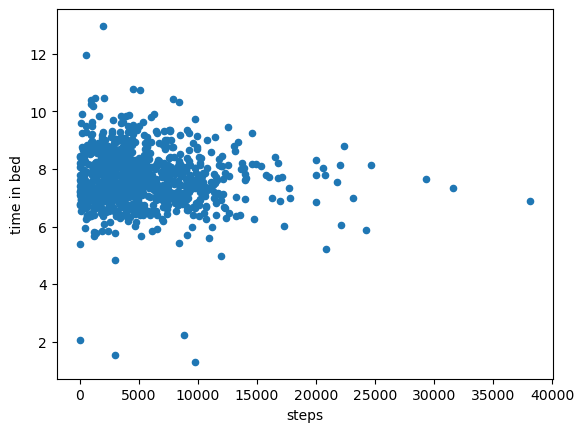

In [23]:
first = "steps"
second = "time in bed"
cleared = sleepset2[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

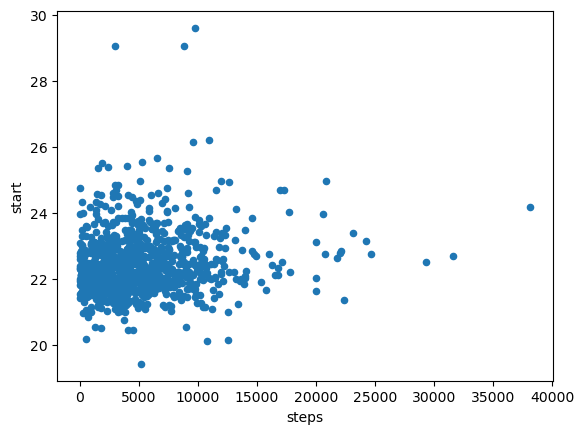

In [24]:
first = "steps"
second = "start"
cleared = sleepset2[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

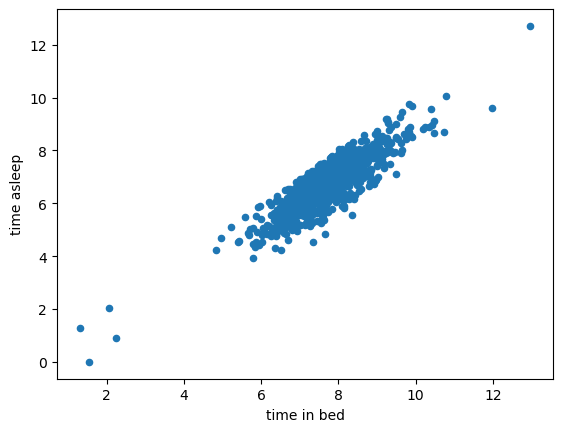

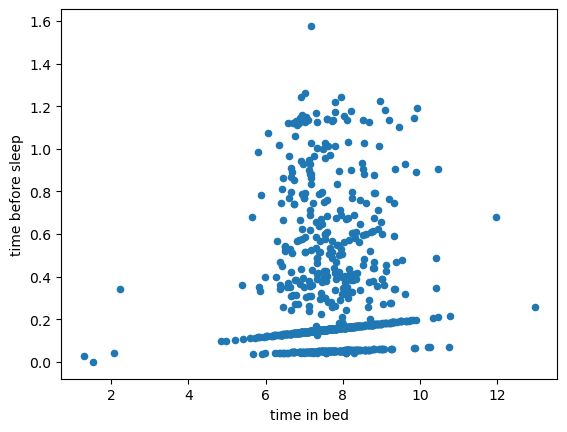

In [25]:
first = "time in bed"
second = "time asleep"
cleared = sleepset2[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

first = "time in bed"
second = "time before sleep"
cleared = sleepset2[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

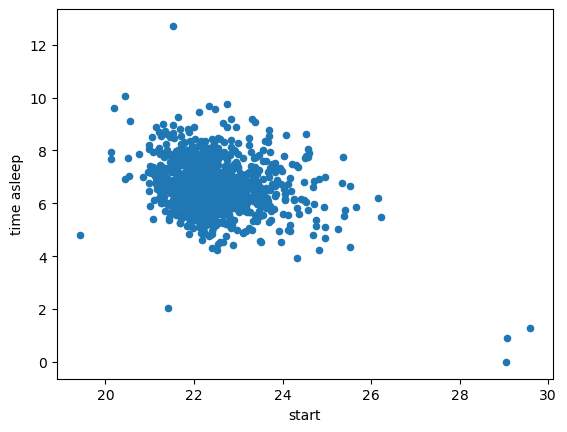

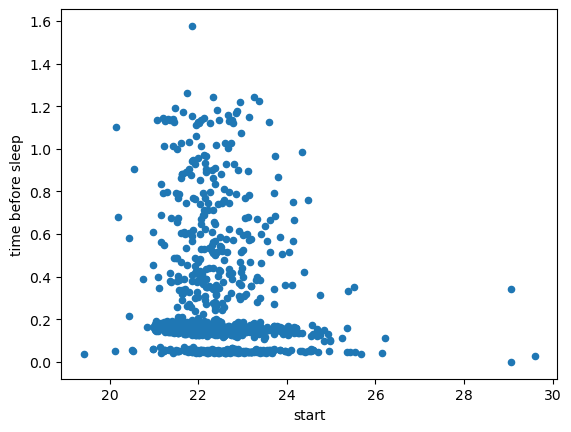

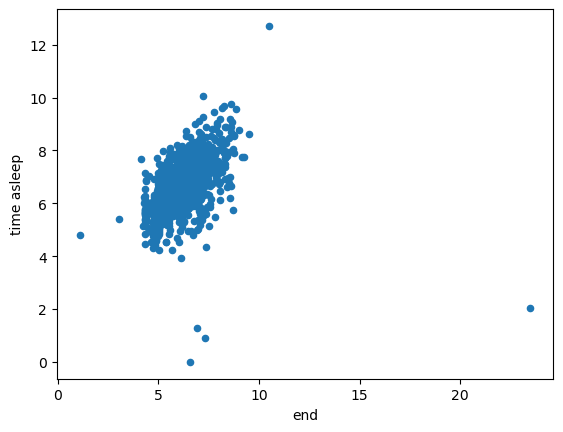

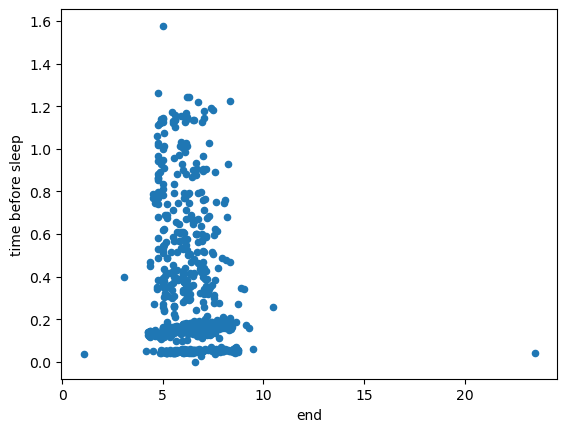

In [26]:
first = "start"
second = "time asleep"
cleared = sleepset2[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

first = "start"
second = "time before sleep"
cleared = sleepset2[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

first = "end"
second = "time asleep"
cleared = sleepset2[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

first = "end"
second = "time before sleep"
cleared = sleepset2[[first, second]].dropna()

cleared.plot(x=first, y=second, kind='scatter')
plt.xlabel(first)
plt.ylabel(second)
plt.show()

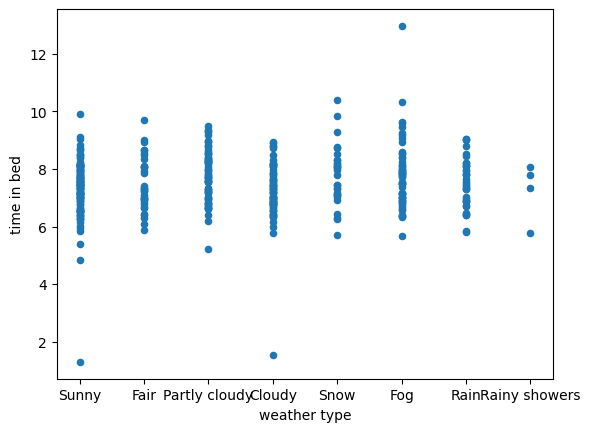

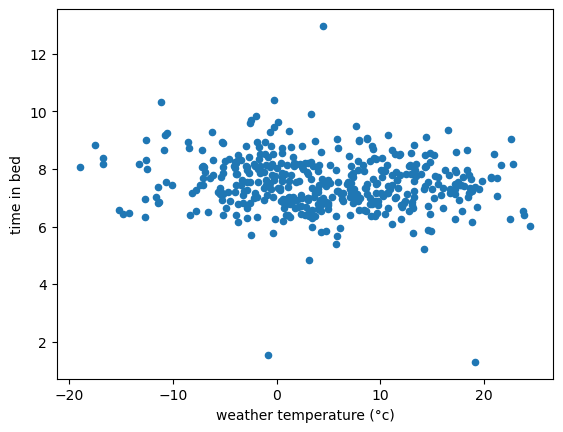

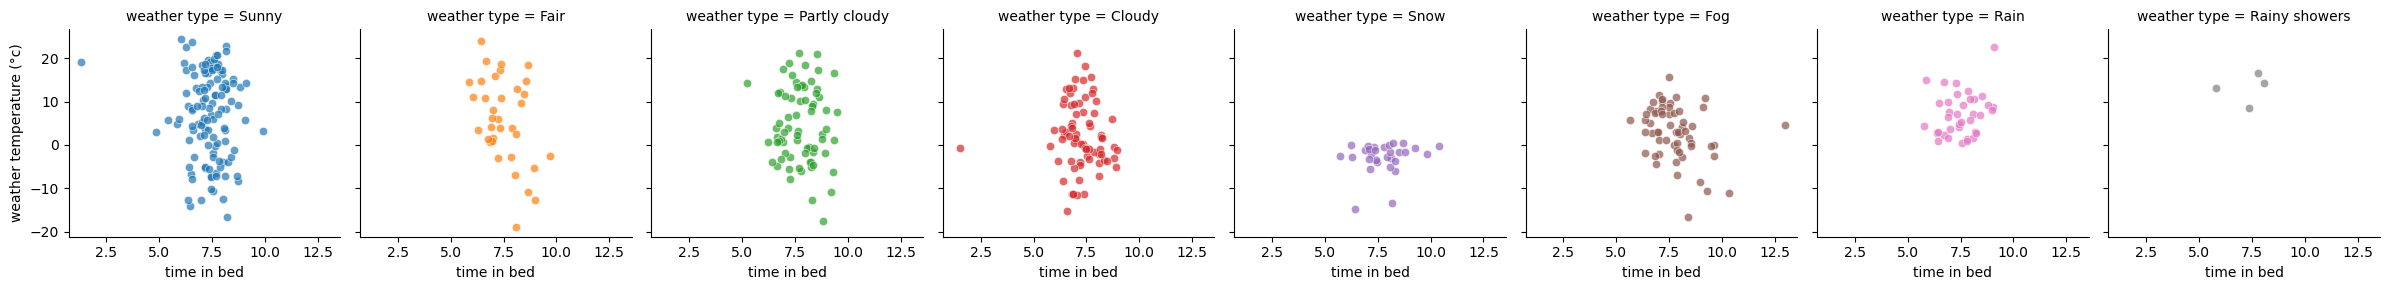

In [27]:
cleared = sleepset2[["time in bed", "weather type", "weather temperature (°c)"]].dropna()
cleared_weather = pd.DataFrame(columns=["time in bed", "weather type"])
cleared_temperature = pd.DataFrame(columns=["time in bed", "weather temperature (°c)"])
cleared_weather_temperature = pd.DataFrame(columns=["time in bed", "weather type", "weather temperature (°c)"])
for index, weather in cleared.iterrows():
    if weather["weather type"] != "No weather":
        cleared_weather.loc[len(cleared_weather.index)] = [weather["time in bed"], weather["weather type"]]
        cleared_temperature.loc[len(cleared_temperature.index)] = [weather["time in bed"], weather["weather temperature (°c)"]]
        cleared_weather_temperature.loc[len(cleared_weather_temperature.index)] = [weather["time in bed"], weather["weather type"], weather["weather temperature (°c)"]]
        
cleared_weather.plot(x = "weather type", y = "time in bed", kind='scatter')
plt.show()
cleared_temperature.plot(x = "weather temperature (°c)", y = "time in bed", kind='scatter')
plt.show()
graph = sb.FacetGrid(cleared_weather_temperature, col = "weather type", hue = "weather type")
graph.map(sb.scatterplot, "time in bed", "weather temperature (°c)", alpha = 0.7)
plt.show()

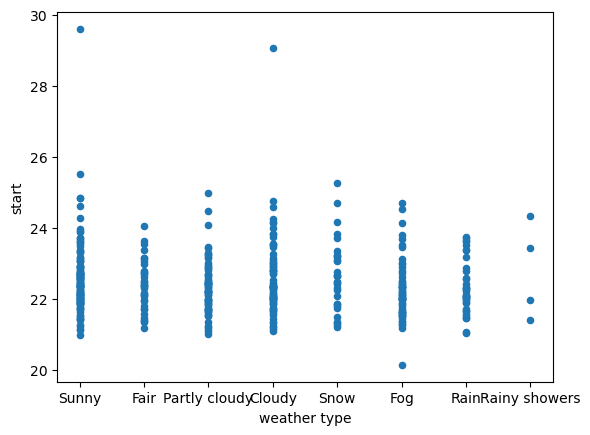

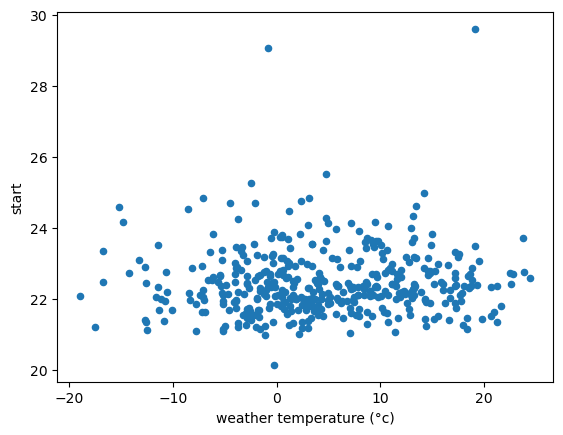

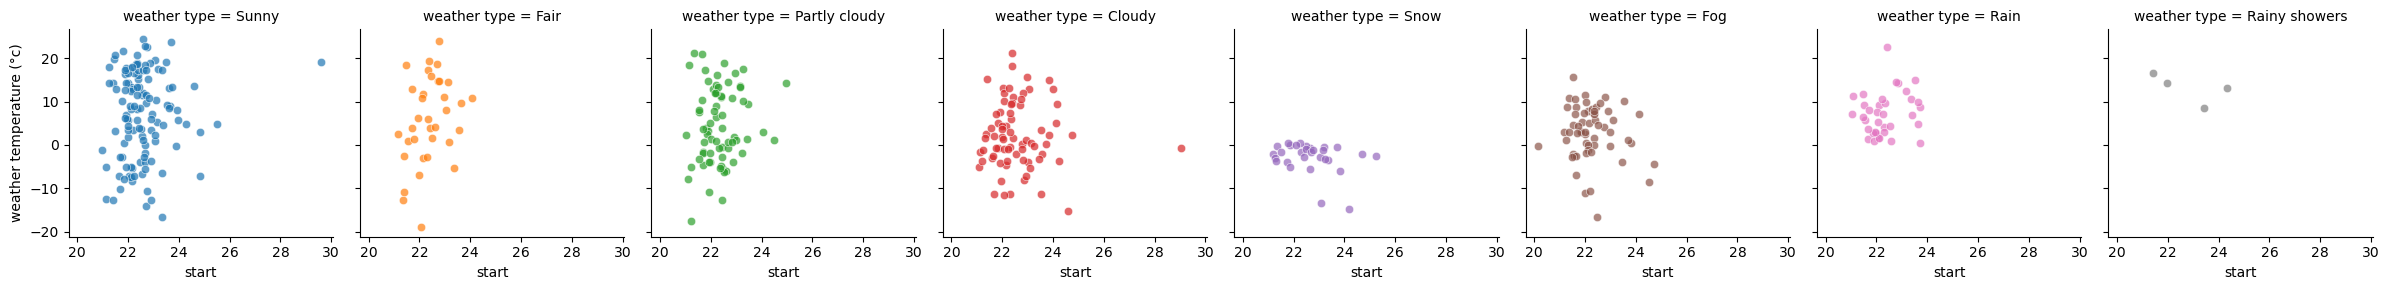

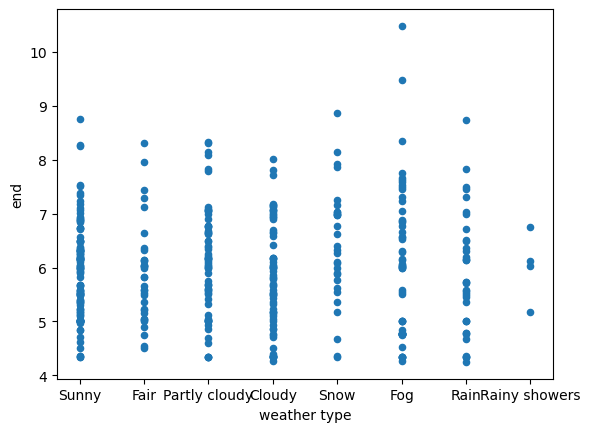

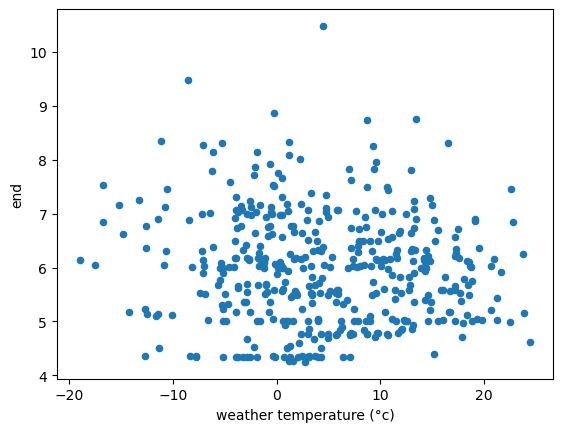

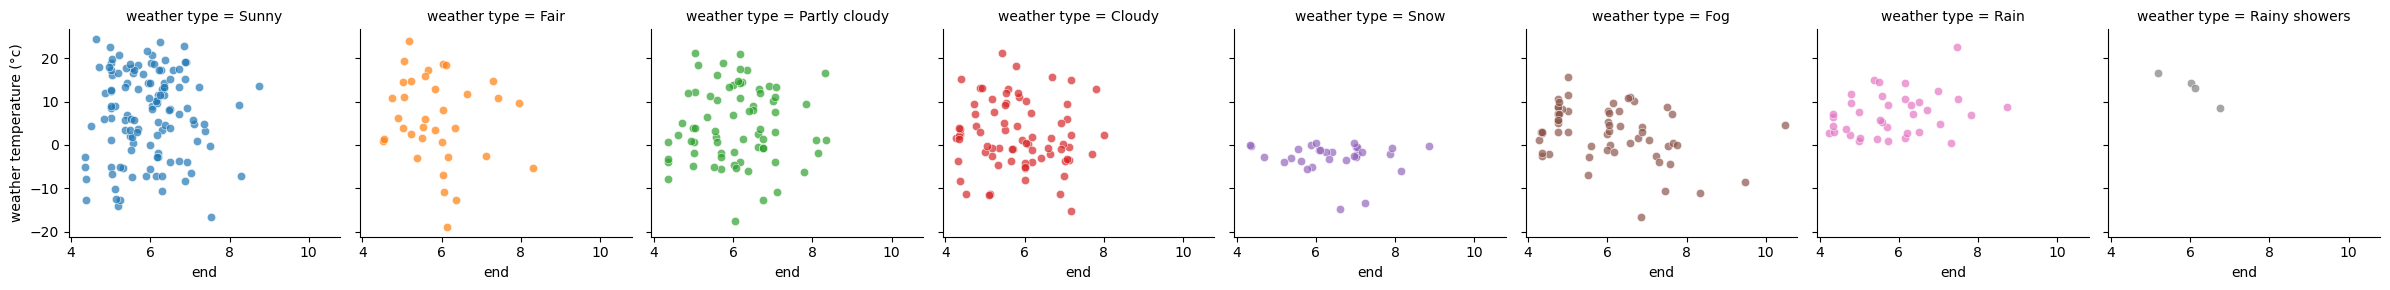

In [28]:
cleared = sleepset2[["start", "weather type", "weather temperature (°c)"]].dropna()
cleared_weather = pd.DataFrame(columns=["start", "weather type"])
cleared_temperature = pd.DataFrame(columns=["start", "weather temperature (°c)"])
cleared_weather_temperature = pd.DataFrame(columns=["start", "weather type", "weather temperature (°c)"])
for index, weather in cleared.iterrows():
    if weather["weather type"] != "No weather":
        cleared_weather.loc[len(cleared_weather.index)] = [weather["start"], weather["weather type"]]
        cleared_temperature.loc[len(cleared_temperature.index)] = [weather["start"], weather["weather temperature (°c)"]]
        cleared_weather_temperature.loc[len(cleared_weather_temperature.index)] = [weather["start"], weather["weather type"], weather["weather temperature (°c)"]]
        
cleared_weather.plot(x = "weather type", y = "start", kind='scatter')
plt.show()
cleared_temperature.plot(x = "weather temperature (°c)", y = "start", kind='scatter')
plt.show()
graph = sb.FacetGrid(cleared_weather_temperature, col = "weather type", hue = "weather type")
graph.map(sb.scatterplot, "start", "weather temperature (°c)", alpha = 0.7)
plt.show()

cleared = sleepset2[["end", "weather type", "weather temperature (°c)"]].dropna()
cleared_weather = pd.DataFrame(columns=["end", "weather type"])
cleared_temperature = pd.DataFrame(columns=["end", "weather temperature (°c)"])
cleared_weather_temperature = pd.DataFrame(columns=["end", "weather type", "weather temperature (°c)"])
for index, weather in cleared.iterrows():
    if weather["weather type"] != "No weather":
        cleared_weather.loc[len(cleared_weather.index)] = [weather["end"], weather["weather type"]]
        cleared_temperature.loc[len(cleared_temperature.index)] = [weather["end"], weather["weather temperature (°c)"]]
        cleared_weather_temperature.loc[len(cleared_weather_temperature.index)] = [weather["end"], weather["weather type"], weather["weather temperature (°c)"]]
        
cleared_weather.plot(x = "weather type", y = "end", kind='scatter')
plt.show()
cleared_temperature.plot(x = "weather temperature (°c)", y = "end", kind='scatter')
plt.show()
graph = sb.FacetGrid(cleared_weather_temperature, col = "weather type", hue = "weather type")
graph.map(sb.scatterplot, "end", "weather temperature (°c)", alpha = 0.7)
plt.show()

More graphs!

Lower: 717 middle: 535 upper: 541 --- lowerline: 22.23 upperline: 22.85


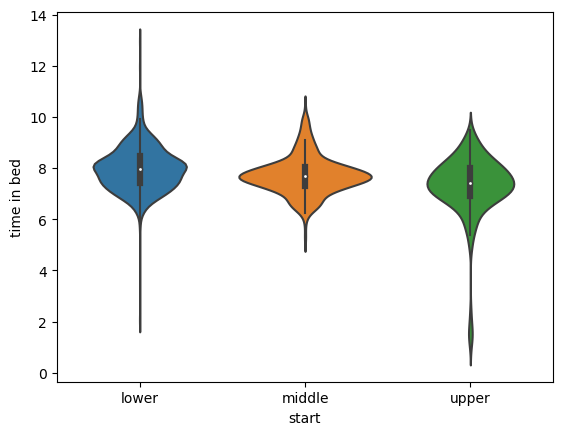

In [29]:
first = "start"
second = "time in bed"
cleared = pd.concat([sleepset1[[first, second]].dropna(), sleepset2[[first, second]].dropna()])

lower = cleared[first].quantile(0.4)
upper = cleared[first].quantile(0.7)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Lower: 710 middle: 542 upper: 541 --- lowerline: 6.05 upperline: 6.633333333333334


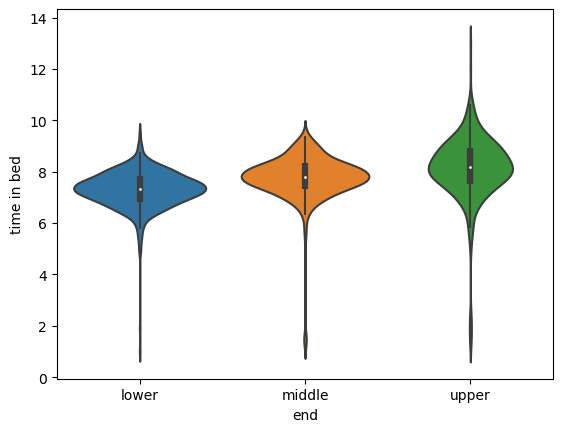

In [30]:
first = "end"
second = "time in bed"
cleared = pd.concat([sleepset1[[first, second]].dropna(), sleepset2[[first, second]].dropna()])

lower = cleared[first].quantile(0.4)
upper = cleared[first].quantile(0.7)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Lower: 32 middle: 108 upper: 21 --- lowerline: 56.0 upperline: 67.0


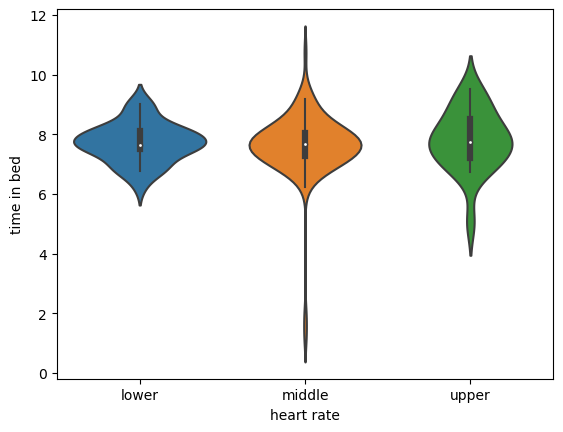

In [38]:
first = "heart rate"
second = "time in bed"
cleared = sleepset1[[first, second]].dropna()

lower = cleared[first].quantile(0.2)
upper = cleared[first].quantile(0.9)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Lower: 367 middle: 274 upper: 276 --- lowerline: 3521.8 upperline: 6556.0


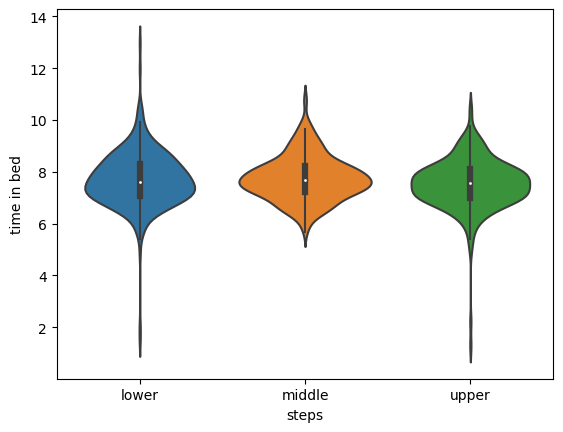

In [32]:
first = "steps"
second = "time in bed"
cleared = sleepset2[[first, second]].dropna()

lower = cleared[first].quantile(0.4)
upper = cleared[first].quantile(0.7)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Lower: 367 middle: 275 upper: 275 --- lowerline: 7.417 upperline: 8.081111111111111


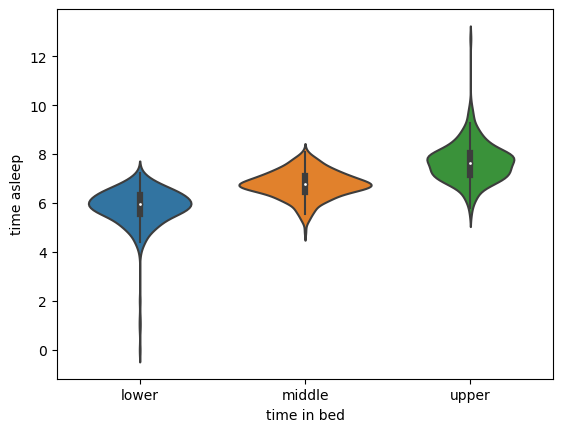

In [33]:
first = "time in bed"
second = "time asleep"
cleared = sleepset2[[first, second]].dropna()

lower = cleared[first].quantile(0.4)
upper = cleared[first].quantile(0.7)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Lower: 367 middle: 275 upper: 275 --- lowerline: 0.1469277777777778 upperline: 0.2599055555555555


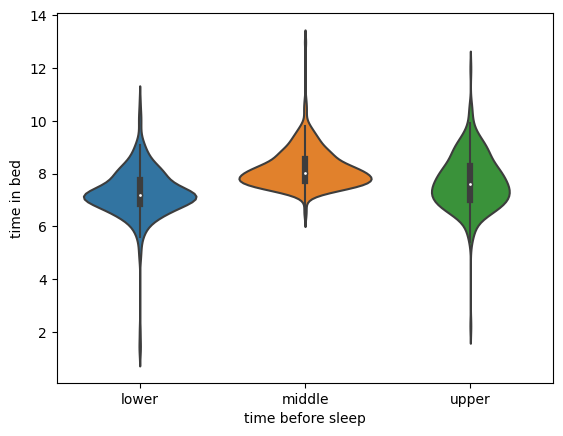

In [34]:
first = "time before sleep"
second = "time in bed"
cleared = sleepset2[[first, second]].dropna()

lower = cleared[first].quantile(0.4)
upper = cleared[first].quantile(0.7)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Lower: 169 middle: 131 upper: 130 --- lowerline: 1.6 upperline: 9.6


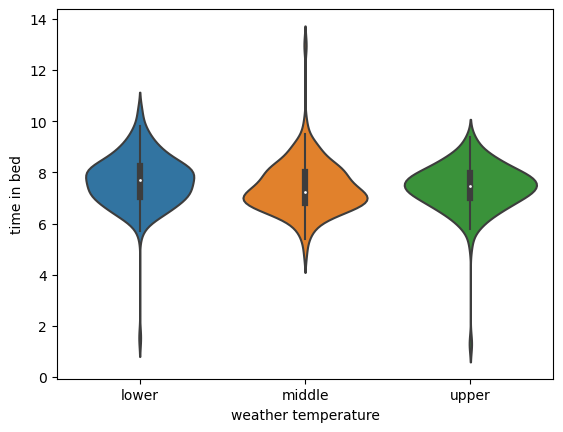

In [35]:
cleared = sleepset2[["time in bed", "weather type", "weather temperature (°c)"]].dropna()
cleared_temperature = pd.DataFrame(columns=["time in bed", "weather temperature"])
for index, weather in cleared.iterrows():
    if weather["weather type"] != "No weather":
        cleared_weather.loc[len(cleared_weather.index)] = [weather["time in bed"], weather["weather type"]]
        cleared_temperature.loc[len(cleared_temperature.index)] = [weather["time in bed"], weather["weather temperature (°c)"]]
        
first = "weather temperature"
second = "time in bed"

lower = cleared_temperature[first].quantile(0.4)
upper = cleared_temperature[first].quantile(0.7)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared_temperature.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Lower: 169 middle: 131 upper: 130 --- lowerline: 1.6 upperline: 9.6


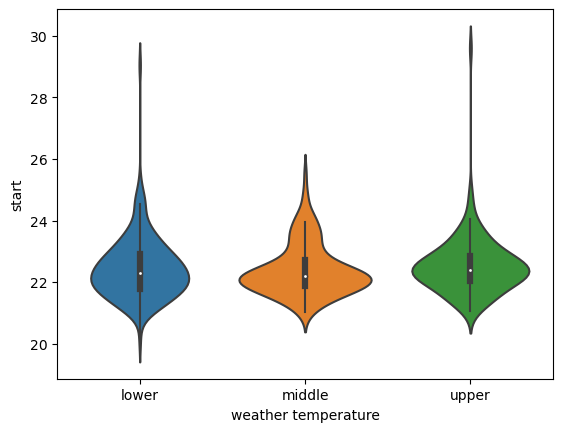

In [36]:
cleared = sleepset2[["start", "weather type", "weather temperature (°c)"]].dropna()
cleared_temperature = pd.DataFrame(columns=["start", "weather temperature"])
for index, weather in cleared.iterrows():
    if weather["weather type"] != "No weather":
        cleared_weather.loc[len(cleared_weather.index)] = [weather["start"], weather["weather type"]]
        cleared_temperature.loc[len(cleared_temperature.index)] = [weather["start"], weather["weather temperature (°c)"]]
        
first = "weather temperature"
second = "start"

lower = cleared_temperature[first].quantile(0.4)
upper = cleared_temperature[first].quantile(0.7)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared_temperature.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Lower: 169 middle: 131 upper: 130 --- lowerline: 1.6 upperline: 9.6


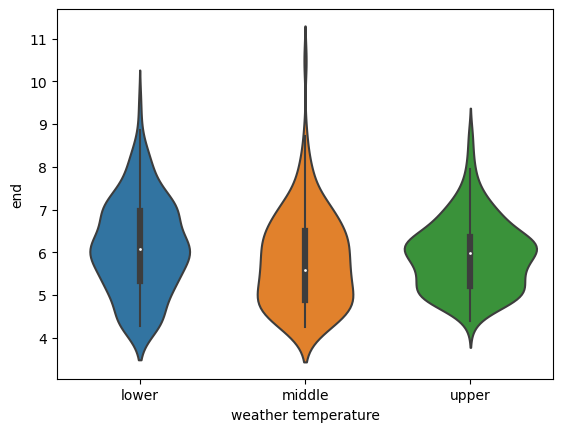

In [37]:
cleared = sleepset2[["end", "weather type", "weather temperature (°c)"]].dropna()
cleared_temperature = pd.DataFrame(columns=["end", "weather temperature"])
for index, weather in cleared.iterrows():
    if weather["weather type"] != "No weather":
        cleared_weather.loc[len(cleared_weather.index)] = [weather["end"], weather["weather type"]]
        cleared_temperature.loc[len(cleared_temperature.index)] = [weather["end"], weather["weather temperature (°c)"]]
        
first = "weather temperature"
second = "end"

lower = cleared_temperature[first].quantile(0.4)
upper = cleared_temperature[first].quantile(0.7)
lowercnt = middlecnt = uppercnt = 0

toshowdata = pd.DataFrame(columns = [first, second])
for index, row in cleared_temperature.iterrows():
    if row[first] < lower:
        toshowdata.loc[len(toshowdata.index)] = ["lower", row[second]]
        lowercnt += 1
    elif row[first] < upper:
        toshowdata.loc[len(toshowdata.index)] = ["middle", row[second]]
        middlecnt += 1
    else:
        toshowdata.loc[len(toshowdata.index)] = ["upper", row[second]]
        uppercnt += 1
print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

sb.violinplot(data = toshowdata.sort_values(first), x = first, y = second)
plt.show()

Итого: Те зависимости, которые мы нашли, есть в презентации, конкретно это:
<ol>
    <li> Вы немного меньше спите при средней температуре, но если брать ваш самый сонный день, то меньше уже при повышенной
    <li> Чем раньше вы засыпаете, тем дольше вы спите
    <li> Возможно, при повышенном пульсе вы чаще дольше спите - данных мало для анализа этого, поэтому это же мы будем анализировать в следующем датасете
</ol>
Сильной зависимости, для подтверждения которой достаточно данных в датасете, помимо найденных нет.

Этот анализ показал что ожидаемо увидеть в следующем датасете